# Import necessary packages

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
import os
import copy
from IPython.display import clear_output
from torchsummary import summary
from tensorboardX import SummaryWriter
import torch.nn.functional as F


In [2]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        resnet_layers = list(models.resnet50(pretrained=True).children())
#         print(resnet_layers)
        self.resnet_1 = nn.Sequential(*resnet_layers[:-5])
        self.resnet_2 = nn.Sequential(*resnet_layers[-5])
        self.resnet_3 = nn.Sequential(*resnet_layers[-4])
        self.resnet_4 = nn.Sequential(*resnet_layers[-3])
        
        self.conv11_resnet_1 = nn.Conv2d(in_channels=256,out_channels=256, kernel_size=(1,1), stride=(1,1))
        self.conv11_resnet_2 = nn.Conv2d(in_channels=512,out_channels=256, kernel_size=(1,1), stride=(1,1))
        self.conv11_resnet_3 = nn.Conv2d(in_channels=1024,out_channels=256, kernel_size=(1,1), stride=(1,1))
        self.conv11_resnet_4 = nn.Conv2d(in_channels=2048,out_channels=256, kernel_size=(1,1), stride=(1,1))
        
        self.scaling_1 = nn.UpsamplingNearest2d(scale_factor=2)
        self.scaling_2 = nn.UpsamplingNearest2d(scale_factor=2)
        self.scaling_3 = nn.UpsamplingNearest2d(scale_factor=2)
        
        self.conv33_td1_1 = nn.Conv2d(in_channels=256, out_channels=128,kernel_size=(3,3),stride=(1,1), padding=(1,1))
        self.conv33_td1_2 = nn.Conv2d(in_channels=128, out_channels=128,kernel_size=(3,3),stride=(1,1), padding=(1,1))
        self.conv33_td2_1 = nn.Conv2d(in_channels=256, out_channels=128,kernel_size=(3,3),stride=(1,1), padding=(1,1))
        self.conv33_td2_2 = nn.Conv2d(in_channels=128, out_channels=128,kernel_size=(3,3),stride=(1,1), padding=(1,1))
        self.conv33_td3_1 = nn.Conv2d(in_channels=256, out_channels=128,kernel_size=(3,3),stride=(1,1), padding=(1,1))
        self.conv33_td3_2 = nn.Conv2d(in_channels=128, out_channels=128,kernel_size=(3,3),stride=(1,1), padding=(1,1))
        self.conv33_td4_1 = nn.Conv2d(in_channels=256, out_channels=128,kernel_size=(3,3),stride=(1,1), padding=(1,1))
        self.conv33_td4_2 = nn.Conv2d(in_channels=128, out_channels=128,kernel_size=(3,3),stride=(1,1), padding=(1,1))
        
        self.scaling_P1 = nn.UpsamplingNearest2d(scale_factor=8)
        self.scaling_P2 = nn.UpsamplingNearest2d(scale_factor=4)
        self.scaling_P3 = nn.UpsamplingNearest2d(scale_factor=2)
        
        self.conv3_final = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=(1,1))
        self.batchnorm_final = nn.BatchNorm2d(512)
        self.activation = nn.ReLU()
        self.conv1_final = nn.Conv2d(in_channels=512, out_channels=2, kernel_size=(1,1), stride=(1,1))
        
        
#         self.scaling = nn.ConvTranspose2d(in_channels=256, out_channels=256,kernel_size=(2,2), stride=2)
        
    def forward(self, x):
        x_bu1 = self.resnet_1(x)
        x_bu2 = self.resnet_2(x_bu1)
        x_bu3 = self.resnet_3(x_bu2)
        x_bu4 = self.resnet_4(x_bu3)
#         print("Bottom-up")
#         print(x_bu1.shape)
#         print(x_bu2.shape)
#         print(x_bu3.shape)
#         print(x_bu4.shape)
        
        
        x_td1 = self.conv11_resnet_4(x_bu4)
        P_1 = self.conv33_td1_1(x_td1)
        P_1 = self.conv33_td1_2(P_1)
        
        x_td2_1 = self.scaling_1(x_td1)
        x_td2_2 = self.conv11_resnet_3(x_bu3)
        x_td2 = x_td2_1+x_td2_2
        P_2 = self.conv33_td2_1(x_td2)
        P_2 = self.conv33_td2_2(P_2)
        
        x_td3_1 = self.scaling_2(x_td2)
        x_td3_2 = self.conv11_resnet_2(x_bu2)
        x_td3 = x_td3_1+x_td3_2
        P_3 = self.conv33_td3_1(x_td3)
        P_3 = self.conv33_td3_2(P_3)
        
        x_td4_1 = self.scaling_3(x_td3)
        x_td4_2 = self.conv11_resnet_1(x_bu1)
        x_td4 = x_td4_1+x_td4_2
        P_4 = self.conv33_td4_1(x_td4)
        P_4 = self.conv33_td4_2(P_4)
        
        
        P_1 = self.scaling_P1(P_1)
        P_2 = self.scaling_P2(P_2)
        P_3 = self.scaling_P3(P_3)
        
        P_concat = torch.cat((P_1, P_2, P_3, P_4), dim=1)
        F = P_concat
#         print("P_concat")
#         print(P_concat.shape)
        
        F = self.conv3_final(F)
        F = self.batchnorm_final(F)
        F = self.activation(F)
        
        F = self.conv1_final(F)
        F = nn.UpsamplingBilinear2d(size = (int(x.size()[-2]),
                                          int(x.size()[-1])))(F)
#         F = nn.Softmax2d()(F)
#         print("Top-down")
#         print(x_td4.shape)
#         print(x_td3.shape)
#         print(x_td2.shape)
#         print(x_td1.shape)
        
#         print("P")
#         print(P_1.shape)
#         print(P_2.shape)
#         print(P_3.shape)
#         print(P_4.shape)
#         print(P_concat.shape)
        
#         print("F")
#         print(x.shape)
#         print(F.shape)
        
        
        return F
with SummaryWriter("runs/MyModel") as w:
    w.add_graph(MyModel(),torch.zeros(1,3,224,224), False)
summary(MyModel(), (3,224,224))

/home/raj/Downloads/y/envs/tm/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingNearest2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/home/raj/Downloads/y/envs/tm/lib/python3.6/site-packages/ipykernel_launcher.py:90: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
/home/raj/Downloads/y/envs/tm/lib/python3.6/site-packages/ipykernel_launcher.py:91: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
/home/raj/Downloads/y

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [3]:
model = MyModel()
out=model(torch.randn((2,3,224,224)))
print(out.shape)
print(out[1,0,1,1], out[1,1,1,1])

torch.Size([2, 2, 224, 224])
tensor(0.1571, grad_fn=<SelectBackward>) tensor(-0.0336, grad_fn=<SelectBackward>)


In [ ]:
for param in model.parameters():
    print(param.requires_grad)

In [ ]:
out.shape

In [4]:
def crossentropy_loss(input_tensor, target=None, weight=None ):
    n,c,h,w = input_tensor.size()
    
    
#     target = target.repeat(1,3,1,1)
#     print(target.size())
#     target_mask = target > 0
#     input_tensor_masked = input_tensor[target_mask]
#     target_masked = target[target_mask]
#     print(input_tensor_masked.size(), target_masked.size())

    input_tensor = input_tensor.transpose(2,1).transpose(2,3).contiguous()
# #     print(input_tensor,target.view(n,h,w,c))
#     print(c)
    input_tensor = input_tensor[target.view(n,h,w,1).repeat(1,1,1,c)>=0].view(-1,c)
    target_mask = target >= 0
    target = target[target_mask]
#     print(input_tensor.size(), input_tensor)
#     print(target.size(), target)
    loss = F.cross_entropy(input_tensor, target, weight=weight, size_average=False)
#     print(loss)
    return loss


In [ ]:
# input_image = torch.randn((,3,224,224))*255
# print(input_image)
label = input_image[:,0,:,:]>0.5
label = label.long()
output=model(input_image)
print(input_image.shape, label.shape)
crossentropy_loss(output, label)

In [ ]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters())
summary = SummaryWriter("runs/Plots")
import matplotlib.pyplot as plt

input_image = plt.imread("./index.png")
# print(input_image.shape)
input_image = torch.FloatTensor(input_image).transpose(1,2).transpose(0,1)
# print(input_image.size())
# print(input_image)
input_image = input_image.repeat(1,1,1,1)[:,:,:224,:224]
label = input_image[:,0,:,:]>=0.5
label = label.long()
# print(label)
# print(label*255)

# input_image = torch.randn((1,3,224,224))*255



print(label.size())
summary.add_images("original_image",input_image)
summary.add_image("label_image", label.float())


input_image = torch.randn(3,3,224,224)
label = label.repeat(3,1,1,1)
for epoch in range(10):
    optimizer.zero_grad()
    # print(input_image)
    
    output=model(input_image)
    print(output.size())
    loss = crossentropy_loss(output, label)
    loss.backward()
    optimizer.step()
    print(epoch,loss)
    print(output.shape)
    print(nn.Softmax2d()(output)[0,0].shape)
#     print(output)
    summary.add_scalar("Loss",loss,epoch)
    summary.add_image("output_images_region1", nn.Softmax2d()(output)[0,0].view(1,224,224), epoch)
    summary.add_image("output_images_region2", nn.Softmax2d()(output)[0,1].view(1,224,224), epoch)
    
    
    

In [ ]:
def test(imgdir):
    input_image = plt.imread(imgdir)
    input_image = torch.FloatTensor(input_image).transpose(1,2).transpose(0,1)
    input_image = input_image.repeat(1,1,1,1)[:,:,:224*3,:224*3]
    print(input_image.size())
    output=model(input_image)
    summary.add_image("test_image", input_image[0,0])
    summary.add_image("test_output_images_region1", nn.Softmax2d()(output)[0,0].view(1,224*3,224*3))
    summary.add_image("test_output_images_region2", nn.Softmax2d()(output)[0,1].view(1,224*3,224*3))

# DataLoader and Preprocessing

In [5]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io, transform
from skimage.draw import polygon
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt


In [6]:
def show_mask_image(image, mask):
    '''
        input image should be of size(h,w,c)
        and mask should be of size(h,w,1) and should contain only 1 for mask
        and 0 for others
    '''
    img, msk = image.copy(), mask.copy()
    
    assert len(img.shape) == 3 and img.shape[2] == 3
    assert len(msk.shape) == 3 or len(msk.shape) == 2
    if len(msk.shape) == 2:
        msk = np.expand_dims(msk, 2)        
    else:
        assert msk.shape[2] == 1
    plt.figure()
    msk = torch.from_numpy(msk).repeat(1,1,3).numpy()
    filter_img = msk == 0
    img[filter_img] = 0
    plt.imshow(img)
    plt.pause(0.01)
    plt.show()

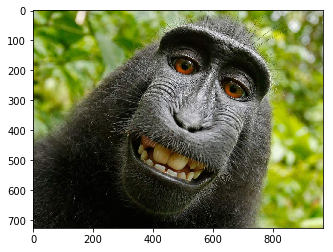

In [7]:
image = io.imread("./index11.jpeg")
mask = np.ones(image.shape[:2])
show_mask_image(image, mask)

In [7]:
'''
This function is an rle to mask converter.
You supply the rle string for one mask, along with it's height and width
from the solutions for stage1 and it will return the mask.
'''

import numpy as np # linear algebra

def rleToMask(rleString,height,width):
    rows,cols = height,width
    rleNumbers = [int(numstring) for numstring in rleString.split(' ')]
    rlePairs = np.array(rleNumbers).reshape(-1,2)
    img = np.zeros(rows*cols,dtype=np.uint8)
    for index,length in rlePairs:
        index -= 1
        img[index:index+length] = 255
    img = img.reshape(rows,cols)
    return img

In [8]:
class Rescale():
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
        
    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']
        h,w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h/w, self.output_size
            else:
                new_h, new_w = self.output_size , self.output_size * w/h
        else:
            new_h, new_w = self.output_size
        new_h, new_w = int(new_h), int(new_w)
        
#         print("Rescale1")
#         print(image.shape, mask.shape)
        
        image = transform.resize(image, (new_h, new_w))
        mask = transform.resize(mask, (new_h, new_w))
        
#         print("Rescale2")
#         print(image.shape, mask.shape)
        
        return {'image':image, 'mask':mask}
class Random_Crop():
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size)==2
            self.output_size = output_size
    
    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']
        h,w = image.shape[:2]
        new_h, new_w = self.output_size
        
        top = np.random.randint(0, h-new_h)
        left = np.random.randint(0, w-new_w)
        
        image = image[top:top+new_h,
                     left:left+new_w]
        mask = mask[top:top+new_h,
                   left:left+new_w]
#         print("Random_Crop")
#         print(image.shape, mask.shape)
        return {'image': image, 'mask': mask}

class ToTensor():
    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']
        image = image.transpose((2,0,1))
#         mask = np.expand_dims(mask, 0)
        mask[mask > 0] = 1
        
        image= torch.from_numpy(image).float()
        mask = torch.from_numpy(mask).long()
        
#         print("ToTensor")
#         print(image.shape, mask.shape)
                    
        return {'image':image,
               'mask': mask}
        
        

In [9]:
class CarvanaDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.mask_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        print(self.mask_frame.head())
    
    def __len__(self):
        return len(self.mask_frame)
    
    def __getitem__(self, idx):
        img_dir = os.path.join(self.root_dir, self.mask_frame.iloc[idx,0])
        image = io.imread(img_dir)
        plt.figure(); plt.imshow(image)
        mask_image = rleToMask(self.mask_frame.iloc[idx,1], image.shape[0], image.shape[1])
#         plt.figure(); plt.imshow(image)
#         plt.figure(); plt.imshow(mask_image)
        sample = {'image': image, 'mask': mask_image}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample
        
        
        
        

In [10]:
trans = transforms.Compose([Rescale(228),
                            Random_Crop(224),
                           ToTensor()])
carvana_dataset = CarvanaDataset('../CarvanaDataset/all/train_masks.csv',
                                '../CarvanaDataset/all/train/',
                                transform=trans)

                   img                                           rle_mask
0  00087a6bd4dc_01.jpg  879386 40 881253 141 883140 205 885009 17 8850...
1  00087a6bd4dc_02.jpg  873779 4 875695 7 877612 9 879528 12 881267 15...
2  00087a6bd4dc_03.jpg  864300 9 866217 13 868134 15 870051 16 871969 ...
3  00087a6bd4dc_04.jpg  879735 20 881650 26 883315 92 883564 30 885208...
4  00087a6bd4dc_05.jpg  883365 74 883638 28 885262 119 885550 34 88716...


In [14]:
dataload = DataLoader(carvana_dataset, batch_size=3, shuffle=False, num_workers=3)

In [19]:
import warnings
warnings.filterwarnings('ignore')
import torchvision
import torchvision.utils as utils

In [ ]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters())
summary = SummaryWriter("runs/Carvana_Plots_train_final_")
import matplotlib.pyplot as plt

for epoch in range(10):
    for count, batch in enumerate(dataload):
        images, masks = batch['image'], batch['mask']
        batch_size = images.size()[0]
        print("Processing Images %d to %d"%(int(batch_size*count+1),int(batch_size*(count+1))))
#         print(images.shape, masks.shape)
        optimizer.zero_grad()
        # print(input_image)

        output=model(images)
#         print(output.size())
        loss = crossentropy_loss(output, masks)
        loss.backward()
        optimizer.step()
        print("Epoch: %d Loss: %d"%(epoch+1,loss))
#         print(output.shape)
    #     print(output)
        summary.add_scalar("Loss",loss, (epoch+1)*(count*batch_size+1))
        
        summary.add_image("input_images",
                          utils.make_grid(images),
                          (count*batch_size+1))
        summary.add_image("mask_images",
                          utils.make_grid(masks.view(-1,1,224,224)),
                          (count*batch_size+1))

        summary.add_image("output_images_region1",
                          utils.make_grid(nn.Softmax2d()(output)[:,0].unsqueeze(1)),
                          (count*batch_size+1))
        summary.add_image("output_images_region2",
                          utils.make_grid(nn.Softmax2d()(output)[:,1].unsqueeze(1)),
                          (count*batch_size+1))

    
    

Processing Images 1 to 3
Epoch: 1 Loss: 5998
Processing Images 4 to 6
Epoch: 1 Loss: 4407
Processing Images 7 to 9
Epoch: 1 Loss: 5423
Processing Images 10 to 12
Epoch: 1 Loss: 4689
Processing Images 13 to 15
Epoch: 1 Loss: 5932
Processing Images 16 to 18
Epoch: 1 Loss: 4404
Processing Images 19 to 21
Epoch: 1 Loss: 3851
Processing Images 22 to 24
Epoch: 1 Loss: 5760
Processing Images 25 to 27
Epoch: 1 Loss: 6391
Processing Images 28 to 30
Epoch: 1 Loss: 4935
Processing Images 31 to 33
Epoch: 1 Loss: 5127
Processing Images 34 to 36
Epoch: 1 Loss: 4618
Processing Images 37 to 39
Epoch: 1 Loss: 5197
Processing Images 40 to 42
Epoch: 1 Loss: 6862
Processing Images 43 to 45
Epoch: 1 Loss: 4800
Processing Images 46 to 48
Epoch: 1 Loss: 4939
Processing Images 49 to 51
Epoch: 1 Loss: 7727
Processing Images 52 to 54
Epoch: 1 Loss: 4896
Processing Images 55 to 57
Epoch: 1 Loss: 6395
Processing Images 58 to 60
Epoch: 1 Loss: 5252
Processing Images 61 to 63
Epoch: 1 Loss: 3766
Processing Images 6

In [50]:
nn.Softmax2d()(output)[:,0].unsqueeze(1).size()

torch.Size([3, 1, 224, 224])

In [ ]:
batches = iter(dataload)
for i in range(349):
    print(i)
    batch = next(batches)
images, masks = batch['image'], batch['mask']
print(images.size(), masks.size())
batch_size = images.size()[0]
print("Processing Images %d to %d"%(int(batch_size*count+1),int(batch_size*(count+1))))
#         print(images.shape, masks.shape)
optimizer.zero_grad()
# print(input_image)

output=model(images)
#         print(output.size())
loss = crossentropy_loss(output, masks)

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f757b1a7470>>
Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f757b1a7470>>
Traceback (most recent call last):
  File "/home/raj/Downloads/y/envs/tm/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
Traceback (most recent call last):
  File "/home/raj/Downloads/y/envs/tm/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 713, in _shutdown_workers
  File "/home/raj/Downloads/y/envs/tm/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
    w.join()
  File "/home/raj/Downloads/y/envs/tm/lib/python3.6/multiprocessing/process.py", line 122, in join
    self._shutdown_workers()
    assert self._parent_pid == os.getpid(), 'can only join a child process'
  File "/home/raj/Downloads/y/envs/tm/lib/py

0


  File "/home/raj/Downloads/y/envs/tm/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


1
2
3
4
5
6
7
8
9
10
11
12
